# #SaveTheExpanse Twitter Campaign Analysis

In [30]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from matplotlib import rcParams
from nltk.corpus import stopwords

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'times new roman'
sns.set(style='whitegrid', context='poster')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Import data and clean

In [3]:
df = pd.read_json('../data/save-the-expanse.json')
df = df.drop(['html', 'id', 'url'], axis='columns')

# Remove 2 records with 'NaN' timestamps
df = df[df['timestamp'].notnull()]

# Convert timestamps to datetime objects and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by = 'timestamp')

# Timestamps are in UTC. Convert to EST.
df['timestamp'] = df['timestamp'] - pd.Timedelta(hours=6)
df = df.set_index('timestamp')

# Why did 'replies' get imported as strings?
df['replies'] = df['replies'].astype(int)

# Limit date range to may
df = df[df.index.month == 5]

# Basic Info

In [6]:
print('Hashtag: #SaveTheExpanse')

start_date = str(min(df.index).date())
end_date = str(max(df.index).date())
print(f'Date range: {start_date} to {end_date}')

num_uniq_tweets = df['text'].nunique()
print(f'Number of unique tweets: {num_uniq_tweets}')

num_tot_tweets = df['retweets'].sum() + num_uniq_tweets
print(f'Number of tweets and retweets: {int(num_tot_tweets)}')

num_tot_tweets_replies = df['replies'].sum() + num_tot_tweets
print(f'Number of tweets, retweets, and replies: {int(num_tot_tweets_replies)}')

num_uniq_users = df['user'].nunique()
print(f'Number of unique users who wrote original tweets: {num_uniq_users}')

Hashtag: #SaveTheExpanse
Date range: 2018-05-10 to 2018-05-31
Number of unique tweets: 46684
Number of tweets and retweets: 166569
Number of tweets, retweets, and replies: 180568
Number of unique users who wrote original tweets: 13596


# Most prolific tweeters

Text(0.5,1,'Most prolific tweeters')

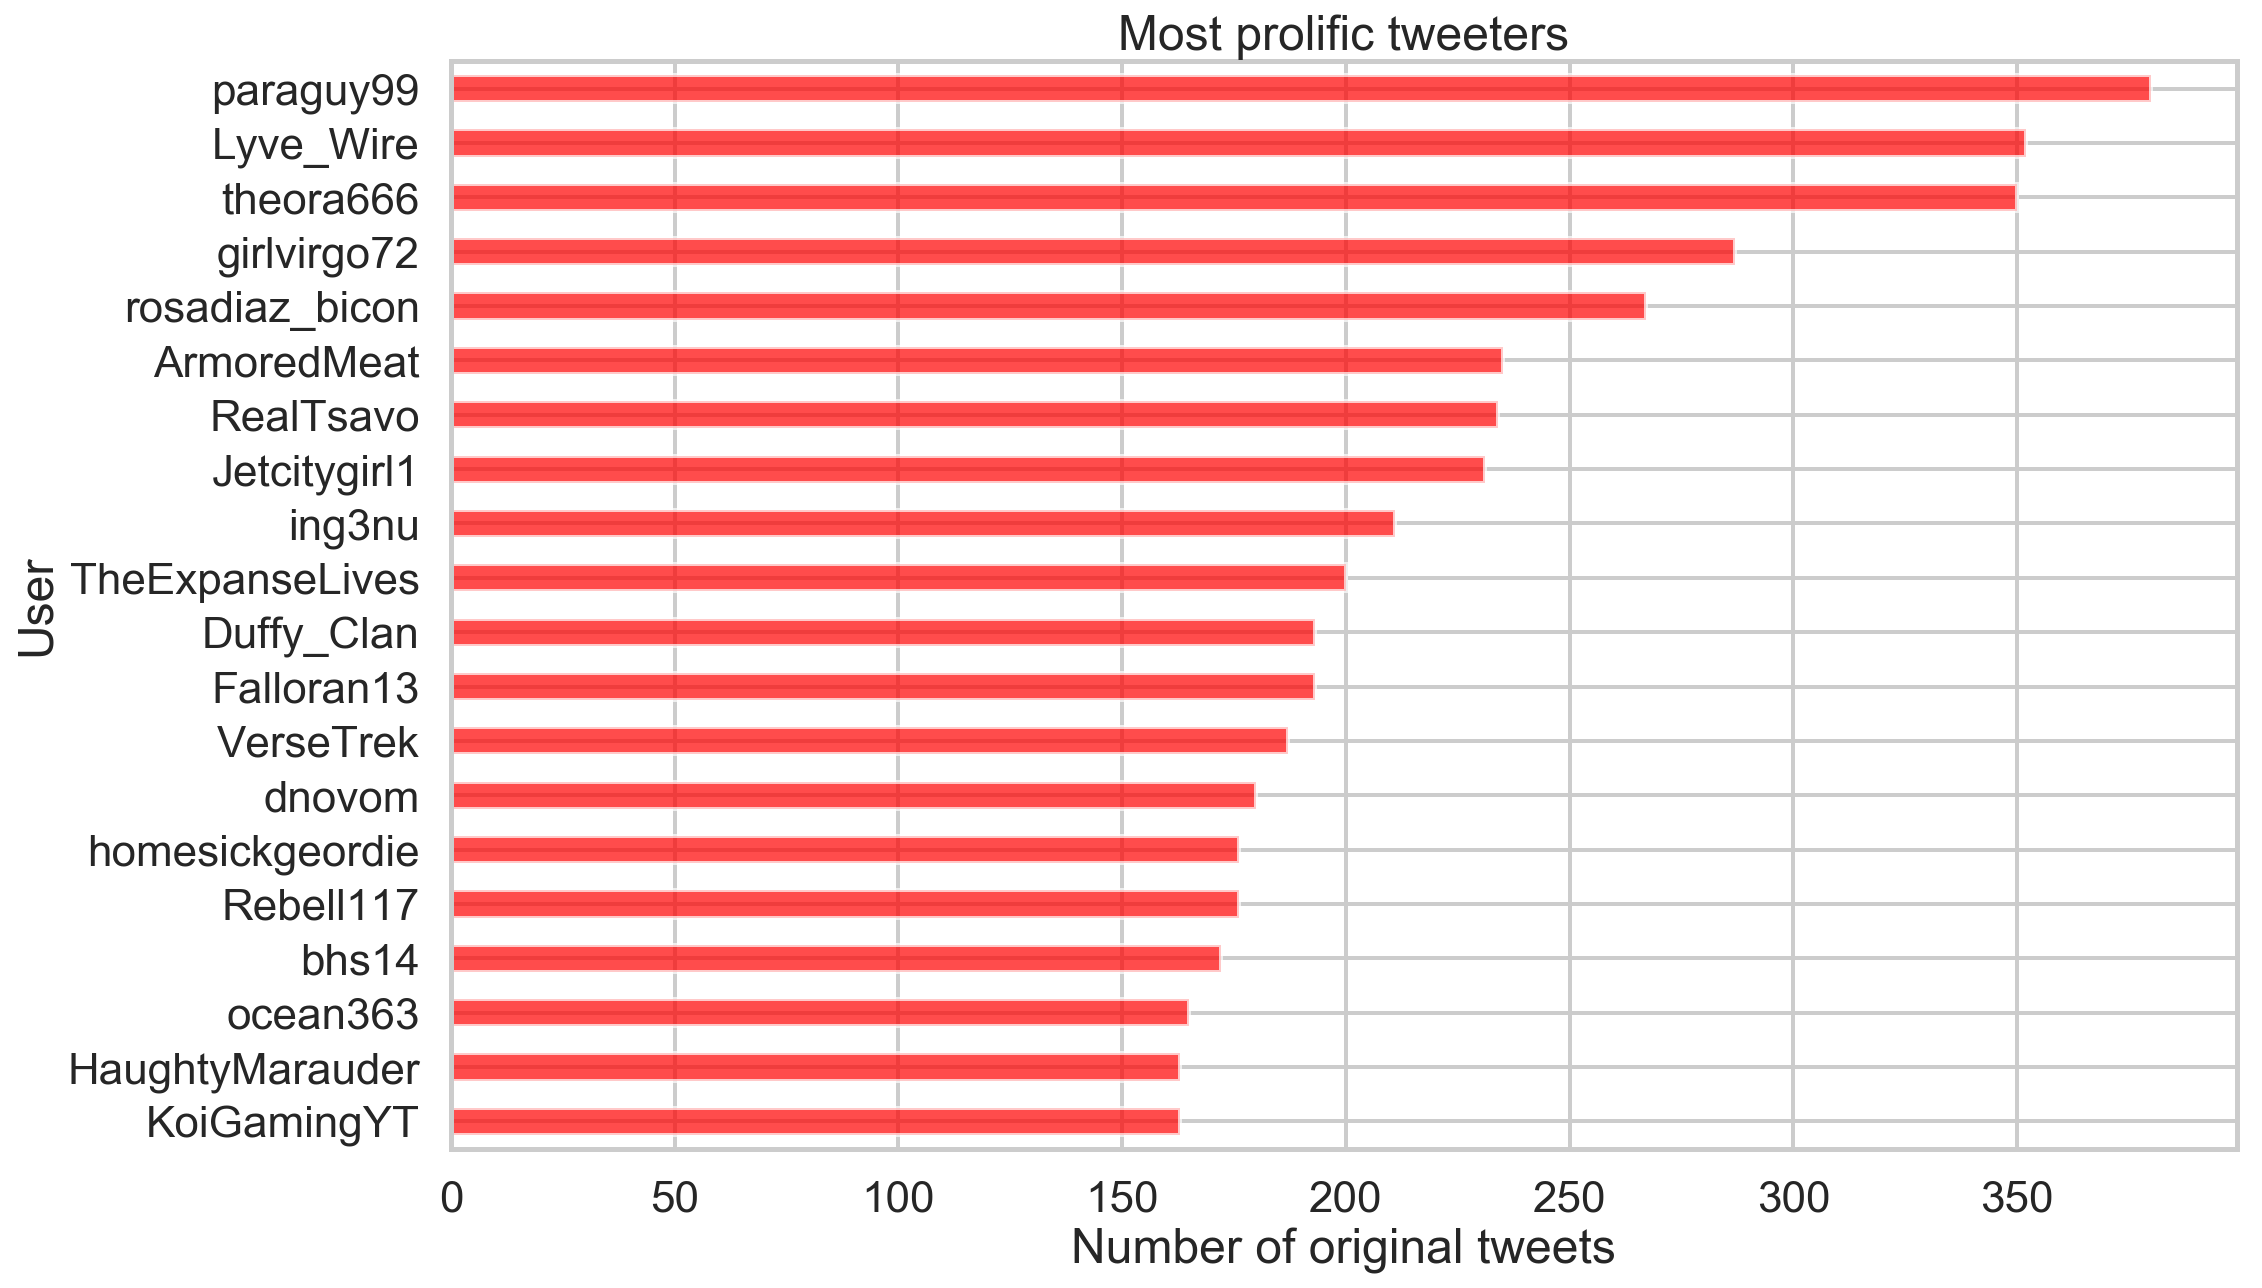

In [8]:
most_prolific = df['user'].value_counts().head(20)
most_prolific = most_prolific.sort_values(ascending=True)
ax = most_prolific.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16,10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of original tweets')
ax.set_title('Most prolific tweeters')

### Prolific $\neq$ High-quality

In [9]:
df[df['user'] == 'paraguy99'].sample(20).text

timestamp
2018-05-20 18:34:04                     51 #SaveTheExpanse
2018-05-20 18:34:48                     64 #SaveTheExpanse
2018-05-23 11:20:25          6 #TheExpanse #savetheexpanse
2018-05-15 21:39:47                      6 #SaveTheExpanse
2018-05-20 18:33:27                     40 #SaveTheExpanse
2018-05-20 18:33:37                     43 #SaveTheExpanse
2018-05-20 18:36:11                     89 #SaveTheExpanse
2018-05-16 22:29:15                      5 #SaveTheExpanse
2018-05-16 22:29:01                      1 #SaveTheExpanse
2018-05-23 11:24:26       With #TheExpanse #savetheexpanse
2018-05-20 18:31:21                      1 #SaveTheExpanse
2018-05-16 22:29:53                      I #SaveTheExpanse
2018-05-23 11:24:21    Expanse #TheExpanse #savetheexpanse
2018-05-20 18:33:33                     42 #SaveTheExpanse
2018-05-15 21:32:19                    #SaveTheExpanse jkl
2018-05-15 21:35:05                      #SaveTheExpanse L
2018-05-16 22:30:57                   Know #Sa

# Most influential tweeters (by retweets)

Text(0.5,1,'Most influential tweeters')

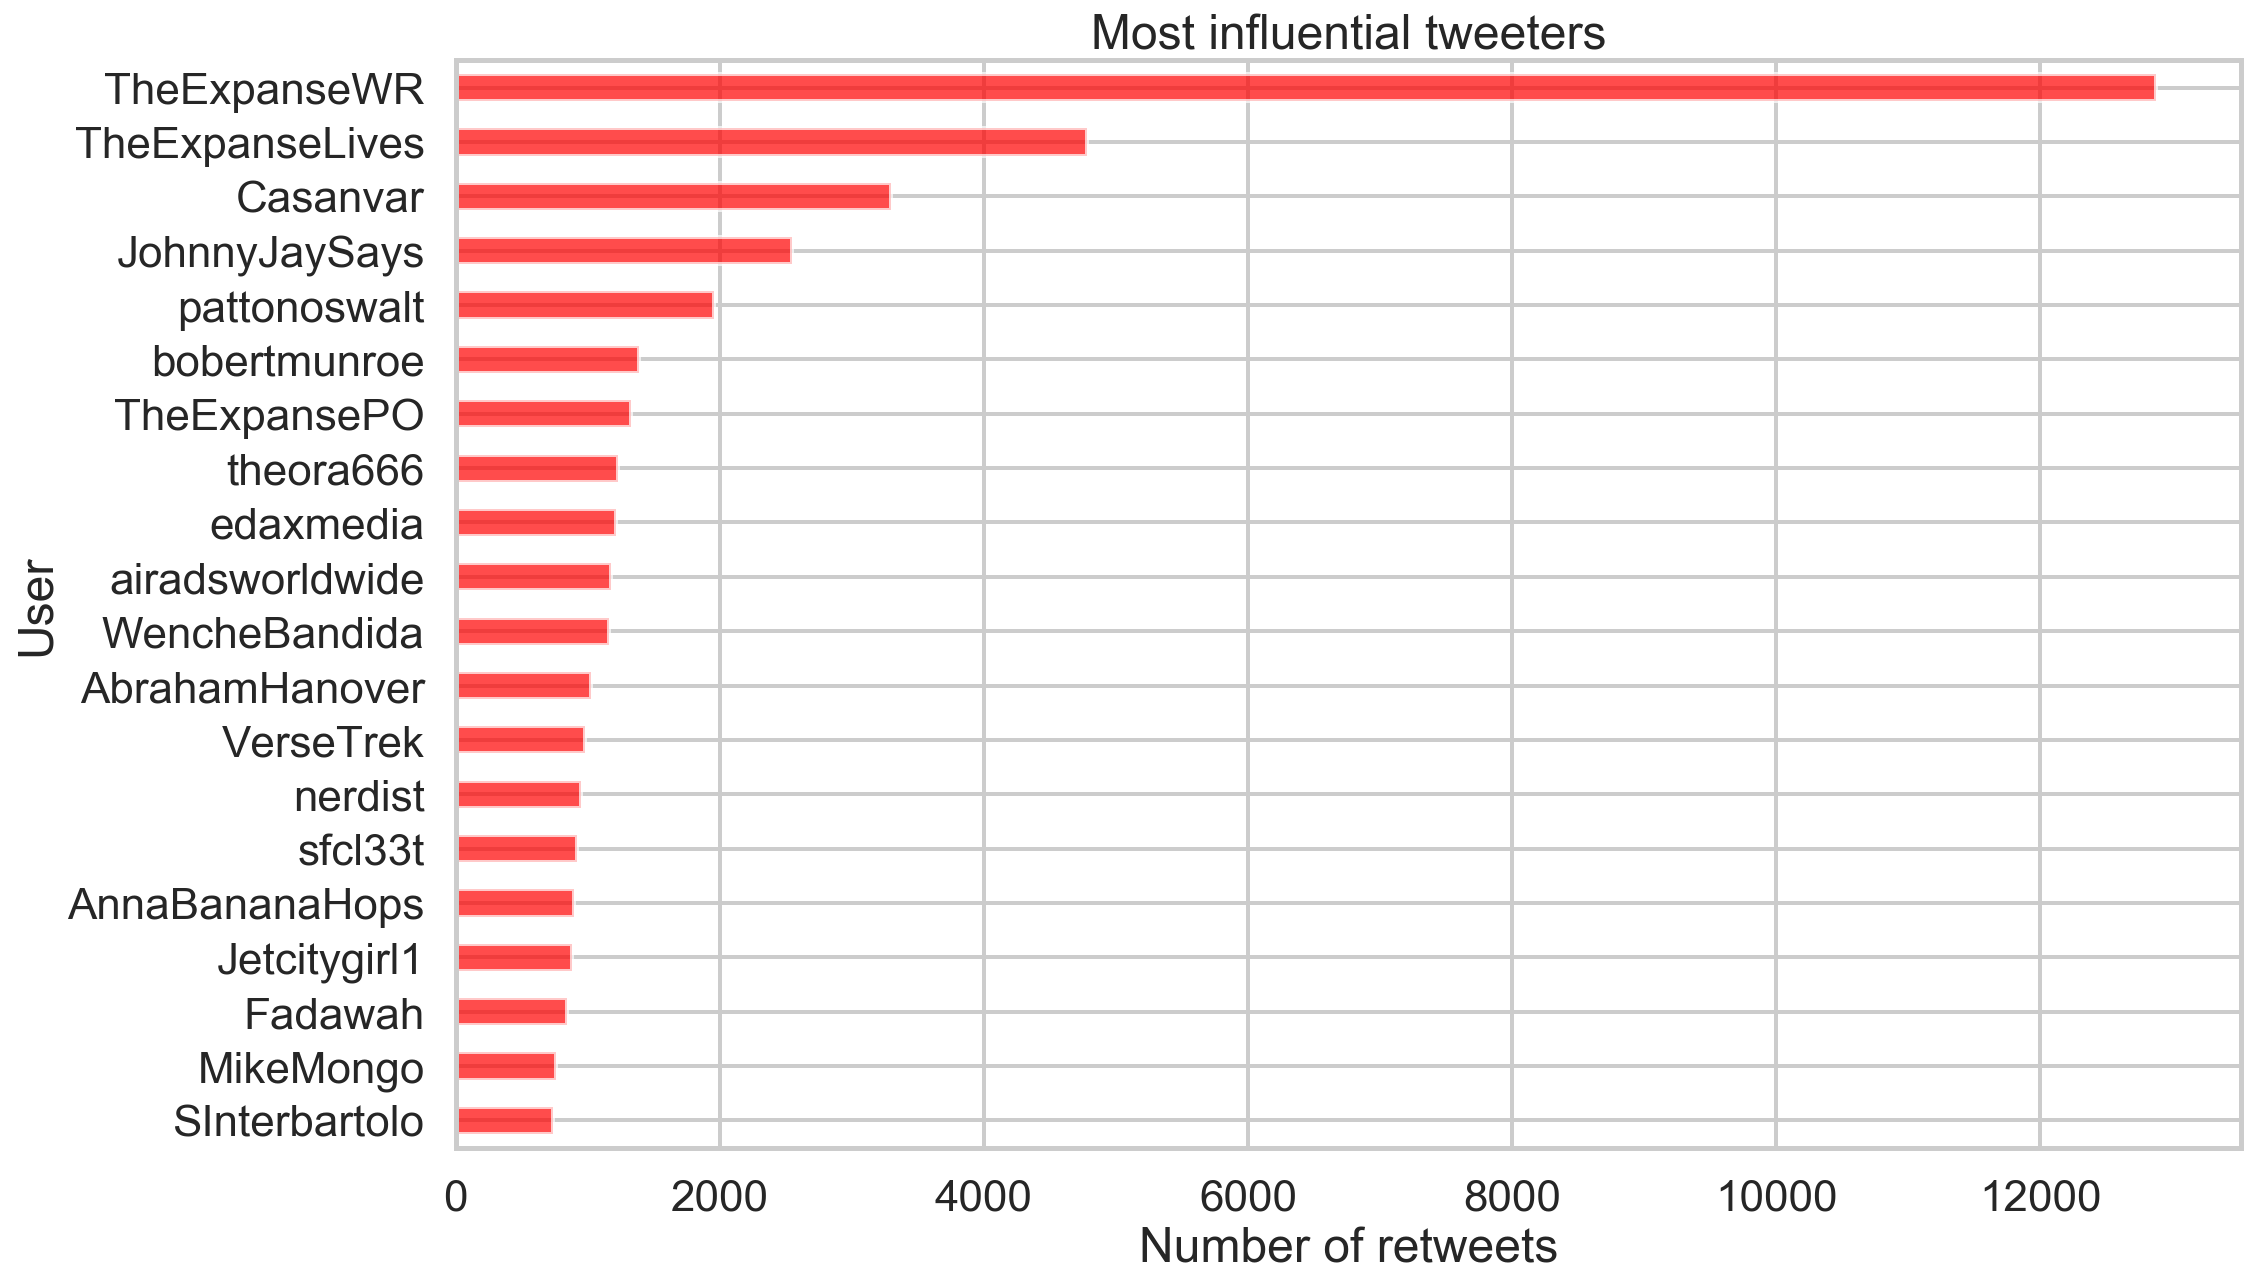

In [11]:
most_influential = df.groupby('user')['retweets'].sum().sort_values().tail(20)
ax = most_influential.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16, 10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of retweets')
ax.set_title('Most influential tweeters')

# Most influential tweeters (by likes)

Text(0.5,1,'Most liked tweeters')

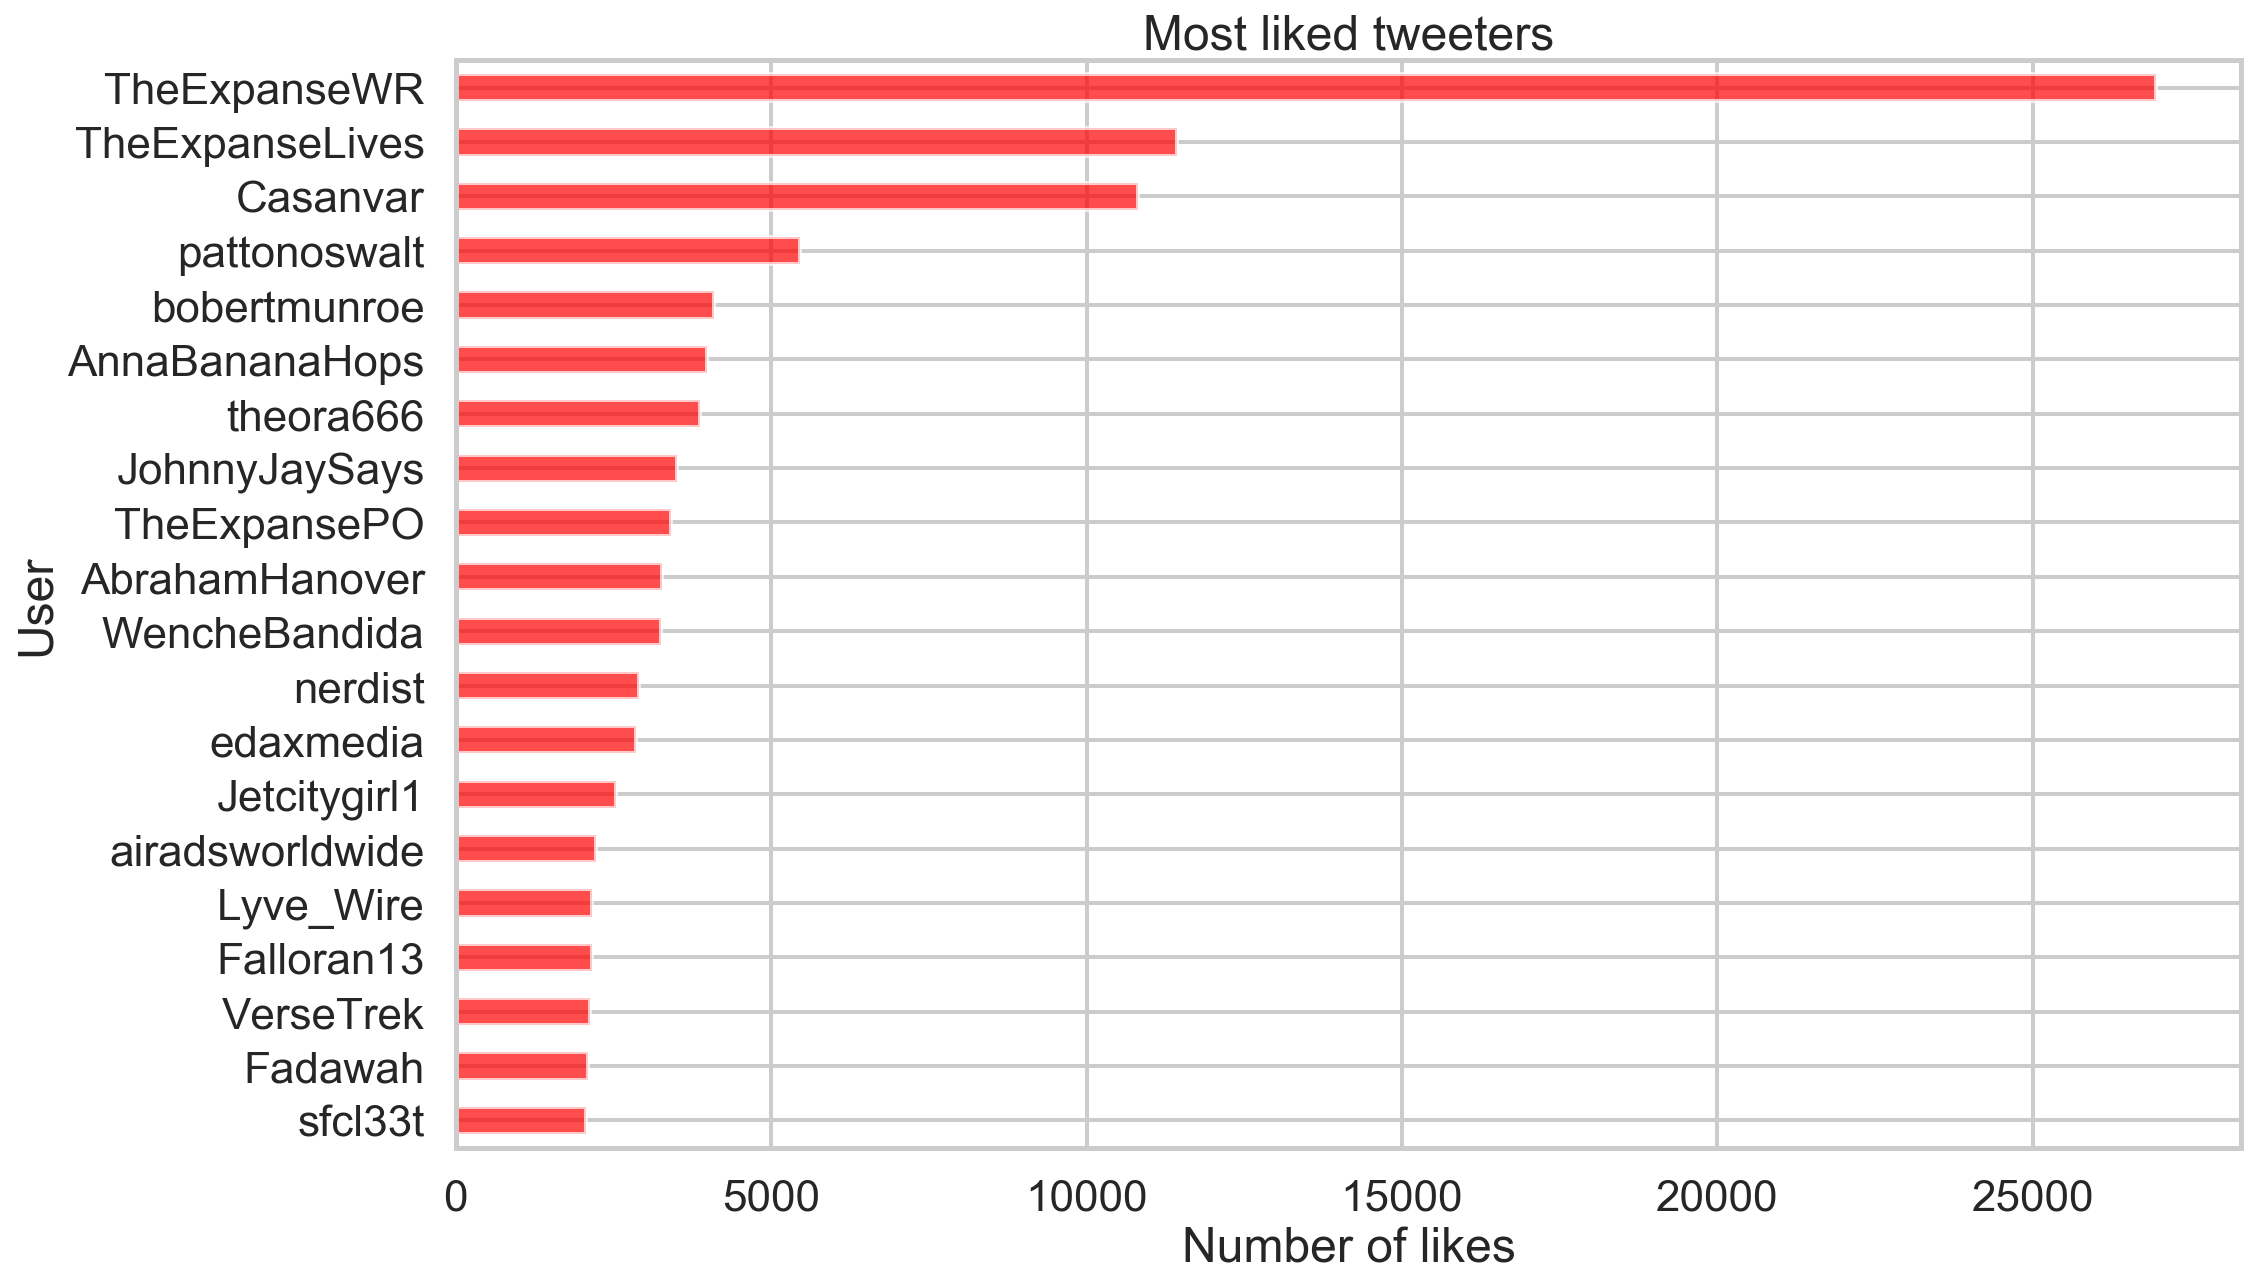

In [14]:
most_influential = df.groupby('user')['likes'].sum().sort_values().tail(20)
ax = most_influential.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16, 10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of likes')
ax.set_title('Most liked tweeters')

# Most influential (normalized by number of tweets)

Text(0.5,1,'Most influential tweeters (normalized)')

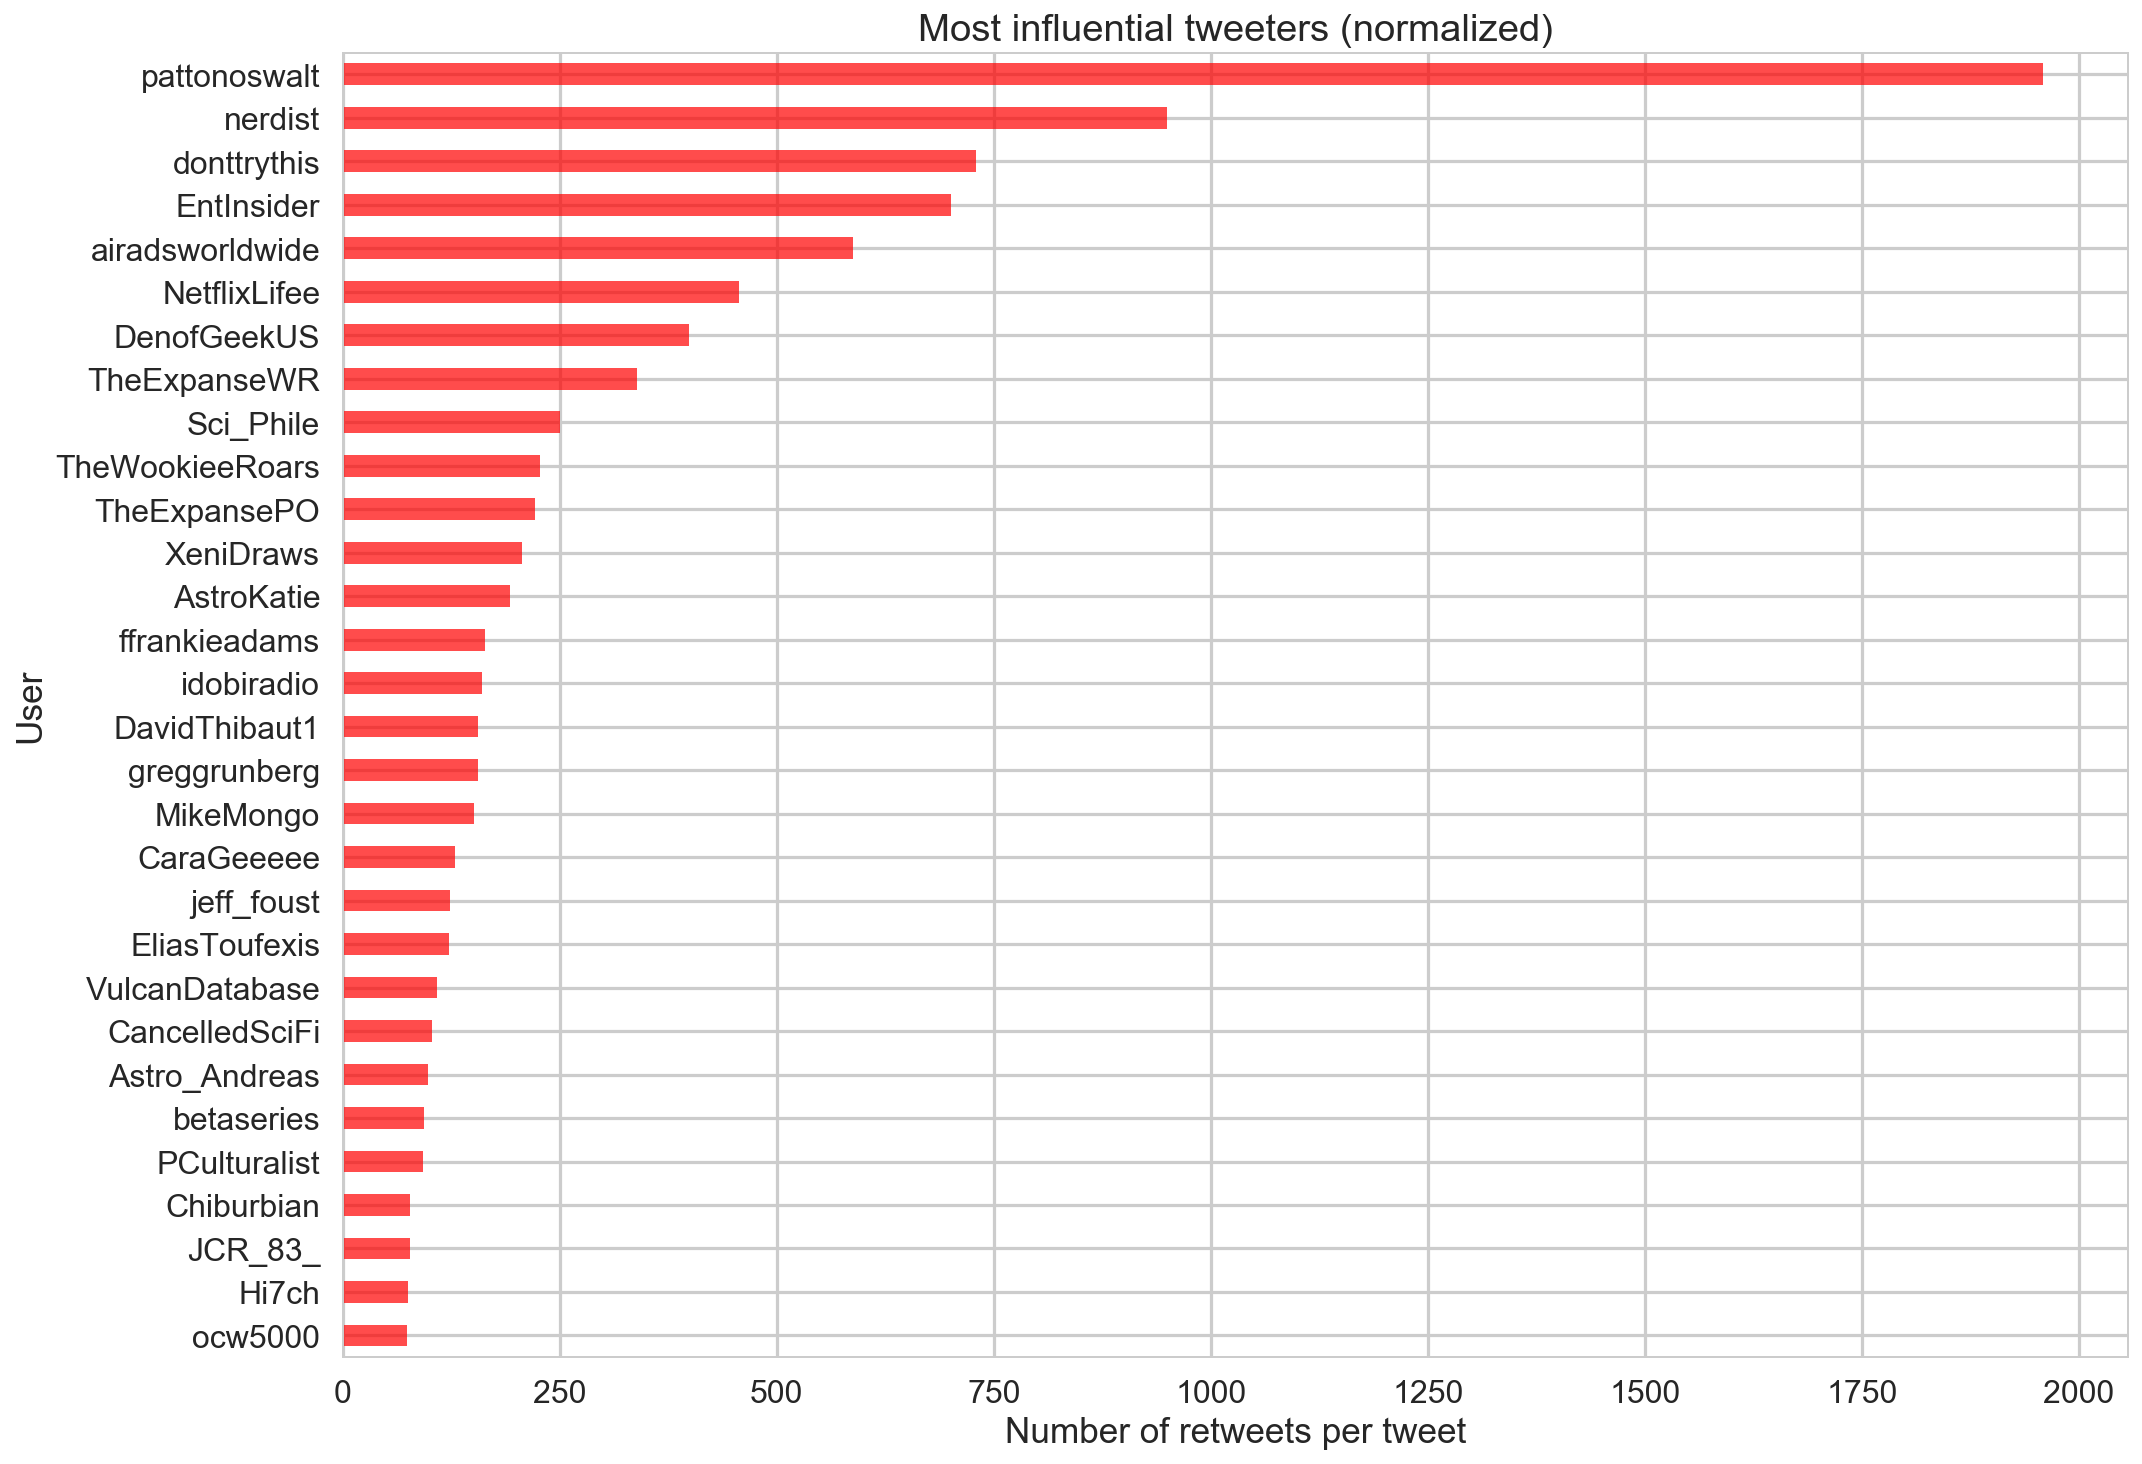

In [183]:
most_influential = df.groupby('user')['retweets'].sum().sort_values()
num_tweets_per_user = df['user'].value_counts()
num_tweets_per_user.name = 'num_tweets'
merged = pd.concat([most_influential, num_tweets_per_user], axis='columns')
most_influential_norm = merged['retweets'] / merged['num_tweets']
most_influential_norm = most_influential_norm.sort_values().tail(30)

ax = most_influential_norm.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16,12),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of retweets per tweet')
ax.set_title('Most influential tweeters (normalized)')

# Engagement time series

Text(0.5,1,'#SaveTheExpanse Engagement Over Time')

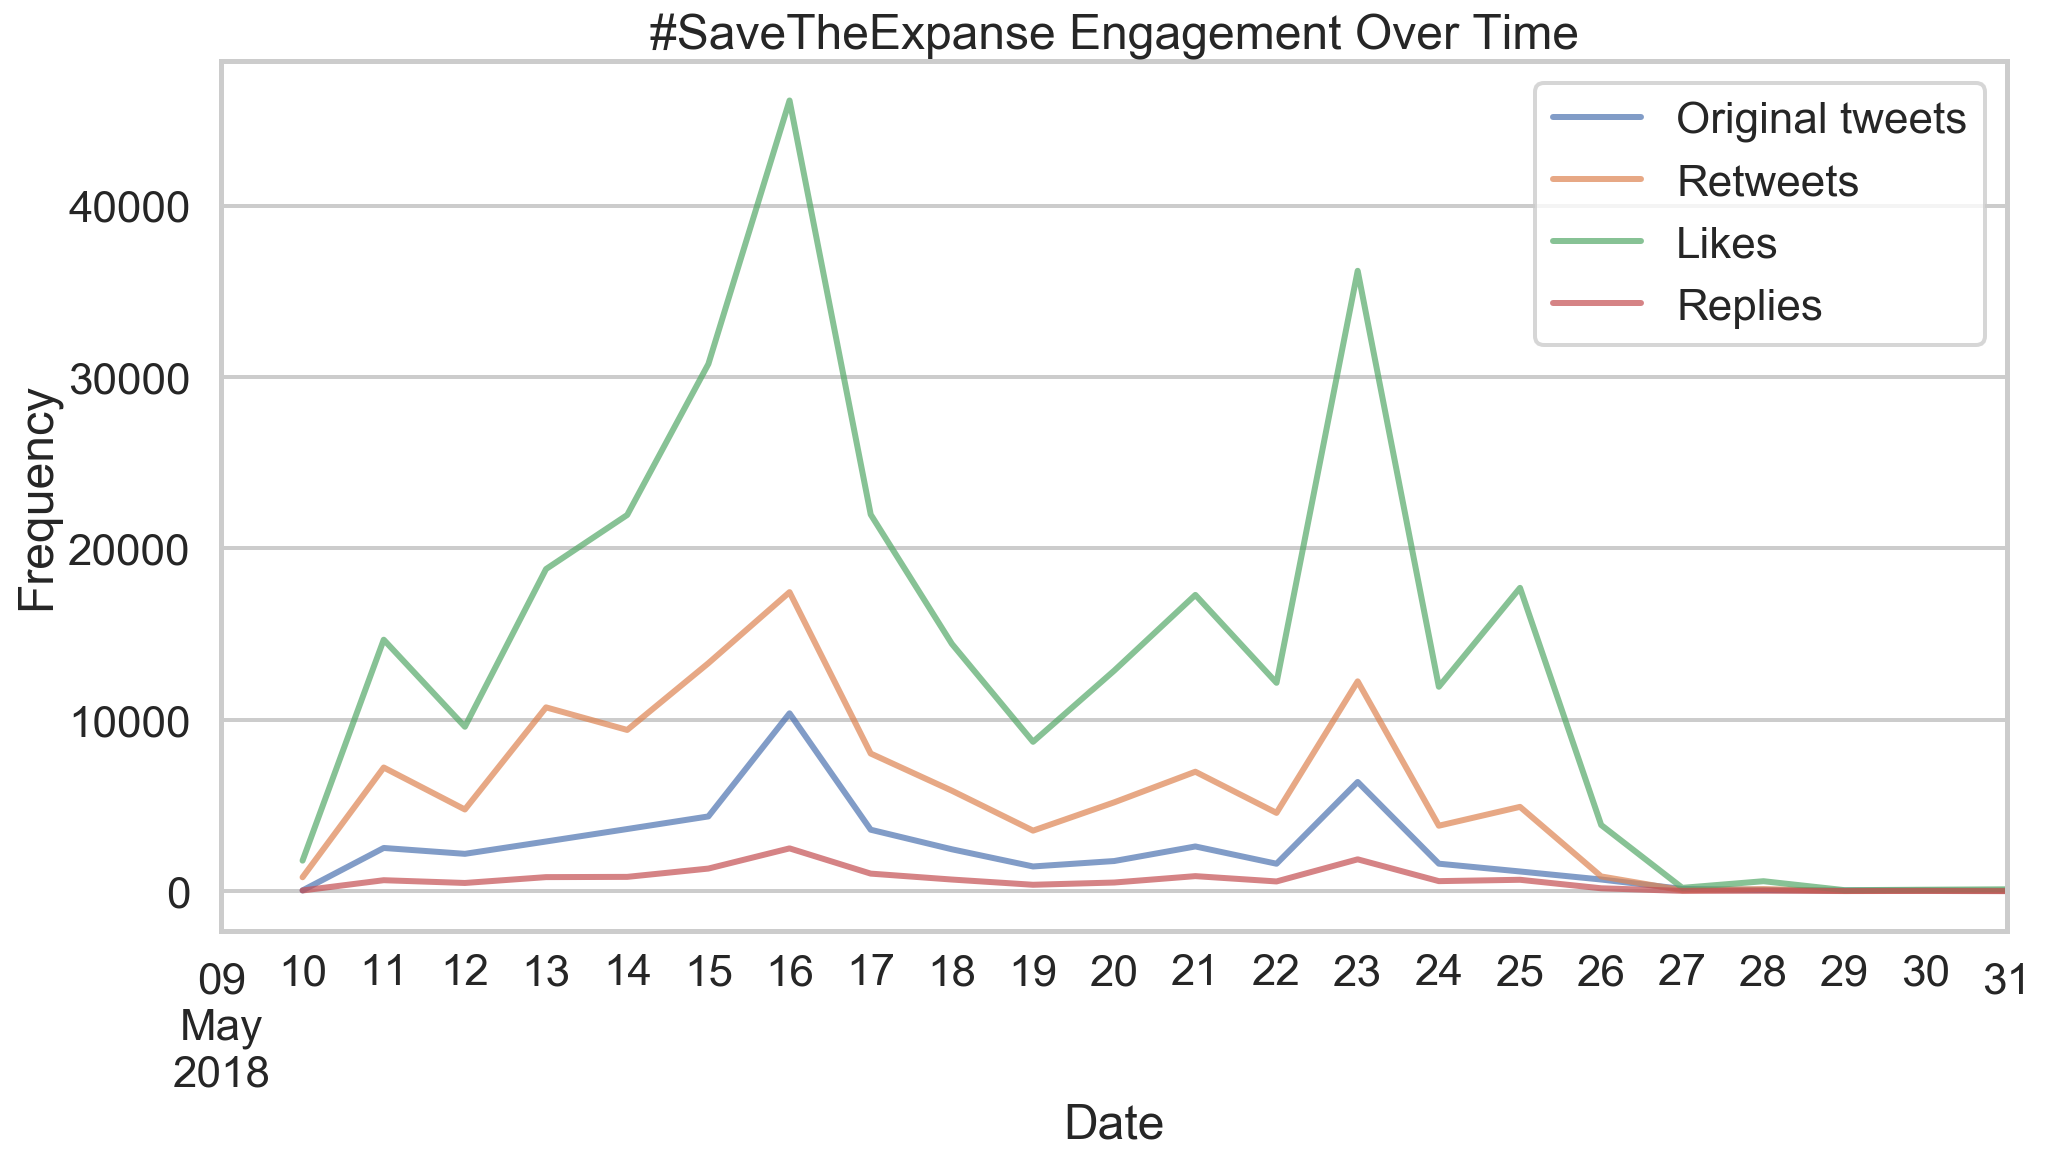

In [15]:
may_num_tweets = df.resample('d').size()
ax = may_num_tweets.plot.line(
    alpha=0.7,
    figsize=(16,8),
    label='Original tweets'
)

for feature in ['retweets', 'likes', 'replies']:
    may_feature = df.resample('d')[feature].sum()
    may_feature.plot.line(
        ax=ax,
        alpha=0.7,
        label=feature.capitalize()
    )

ax.legend()
ax.set_xlim(17660, 17682)
ax.set_ylabel('Frequency')
ax.set_xlabel('Date')
ax.set_title('#SaveTheExpanse Engagement Over Time')

# Secondary hashtags

In [16]:
hashtags = list()
for tweet in df['text'].str.lower():
    hashtags.extend(re.findall(r'#[a-z|\d]*', tweet))
hashtags = pd.Series(hashtags)

[Text(0,0.5,'Hashtag'),
 Text(0.5,0,'Frequency of use in original tweets'),
 Text(0.5,1,'Most popular secondary hashtags')]

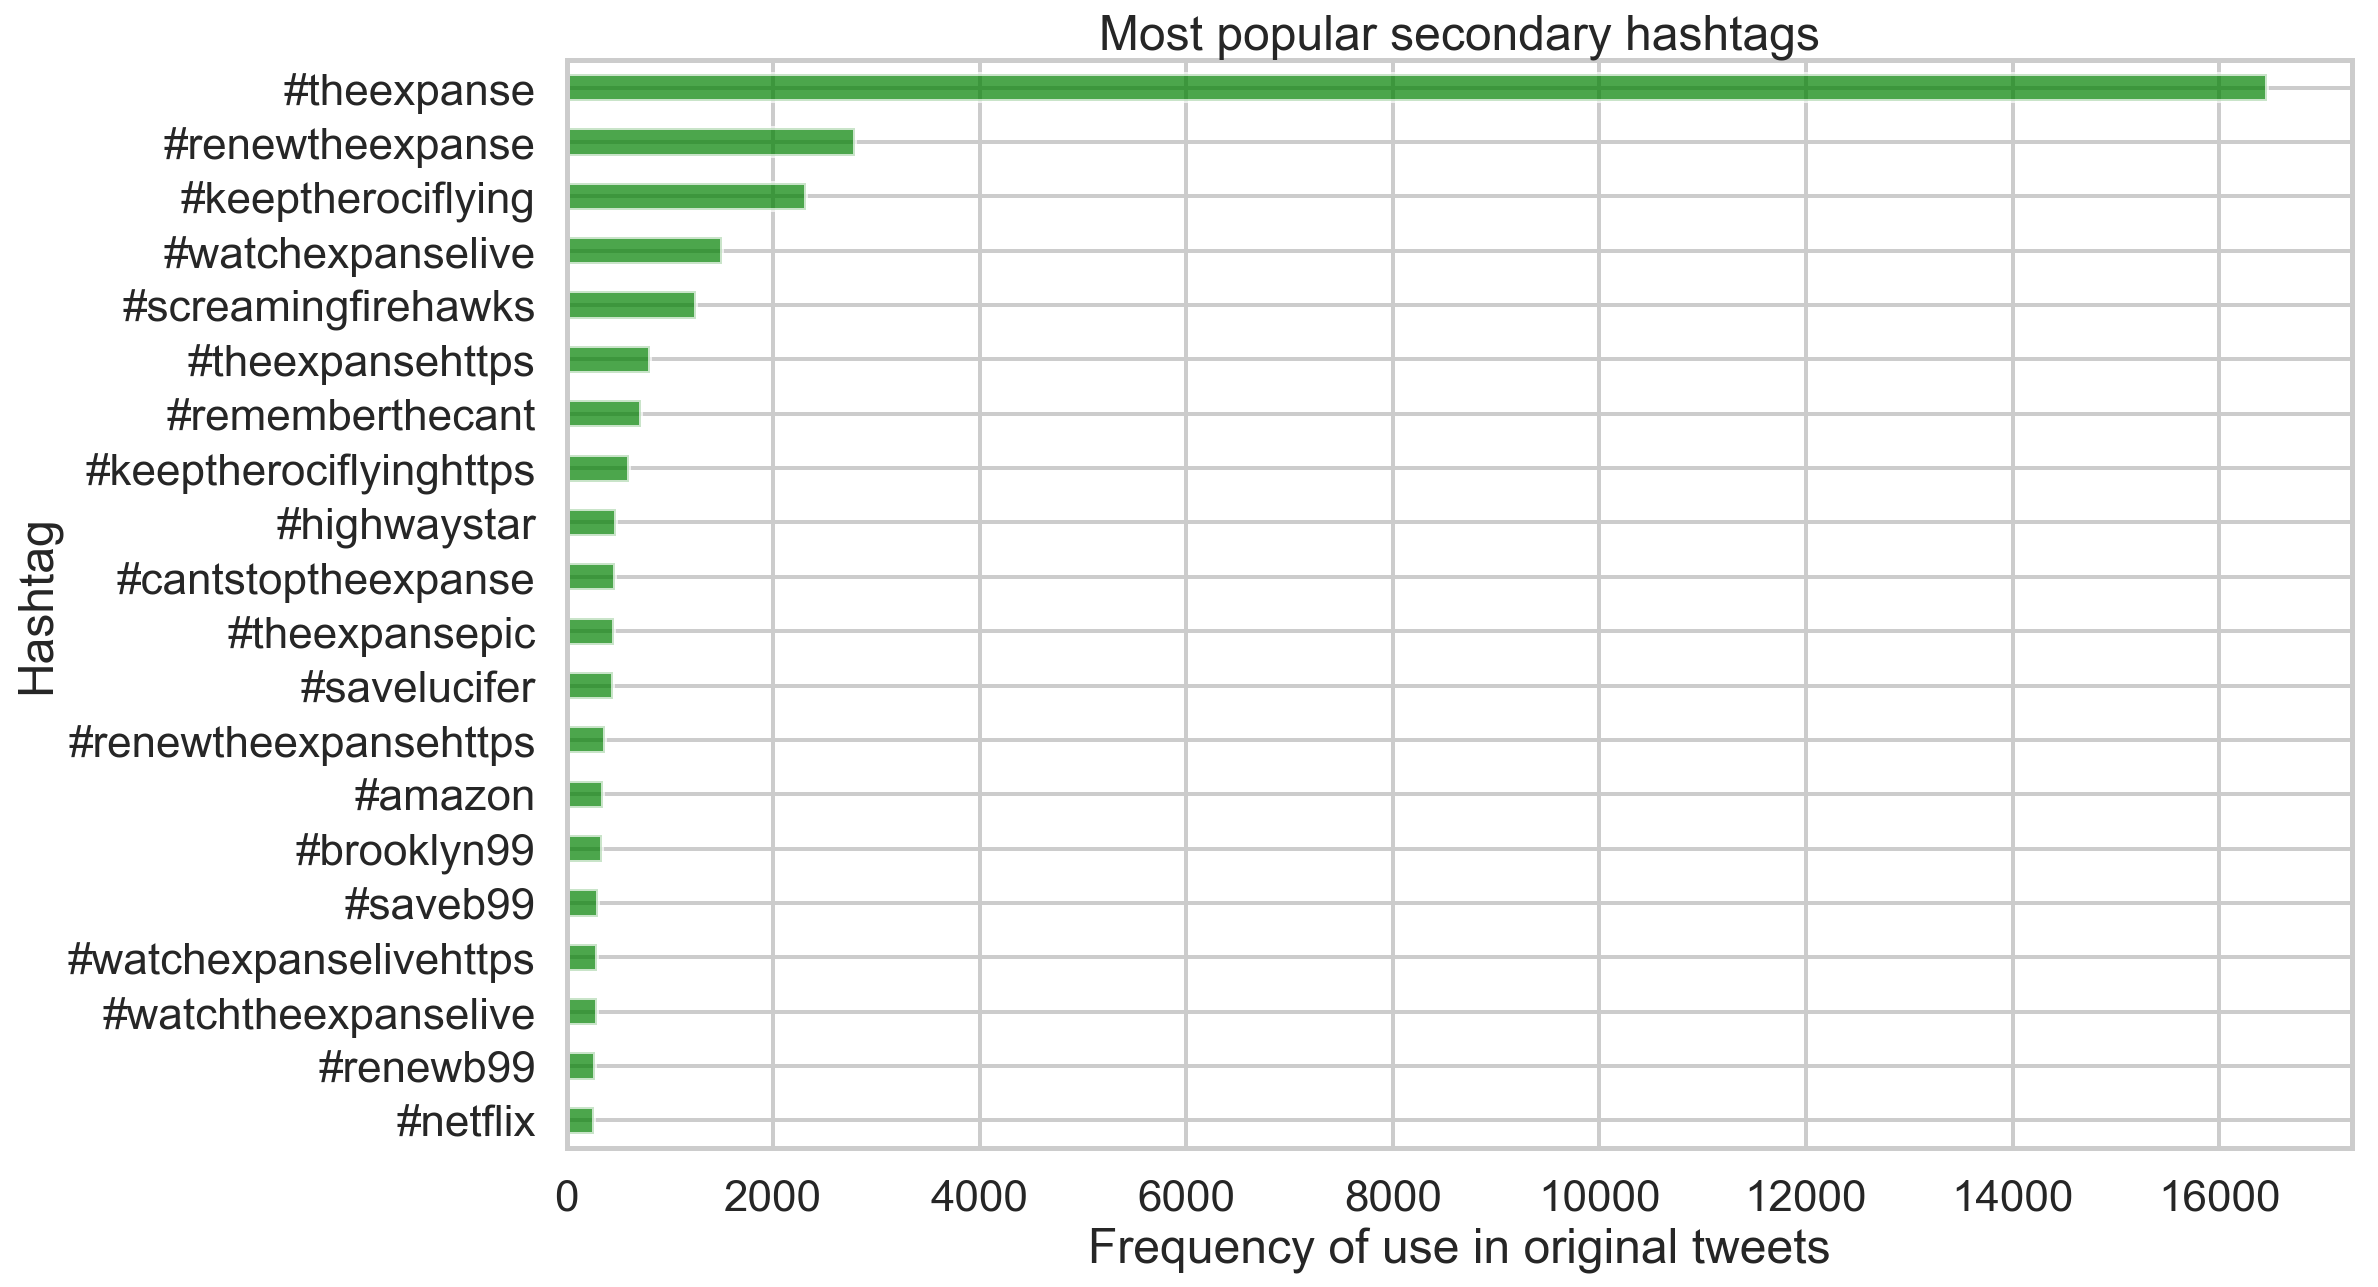

In [18]:
secondary_hashtags = hashtags.value_counts()[1:21]
secondary_hashtags = secondary_hashtags.sort_values(ascending=True)
ax = secondary_hashtags.plot.barh(
    figsize=(16,10),
    color='green',
    alpha=0.7,
)

ax.set(
    title='Most popular secondary hashtags',
    xlabel='Frequency of use in original tweets',
    ylabel='Hashtag'
)

# @'s

[Text(0,0.5,'At'),
 Text(0.5,0,'Frequency of use in original tweets'),
 Text(0.5,1,"Most popular @'s")]

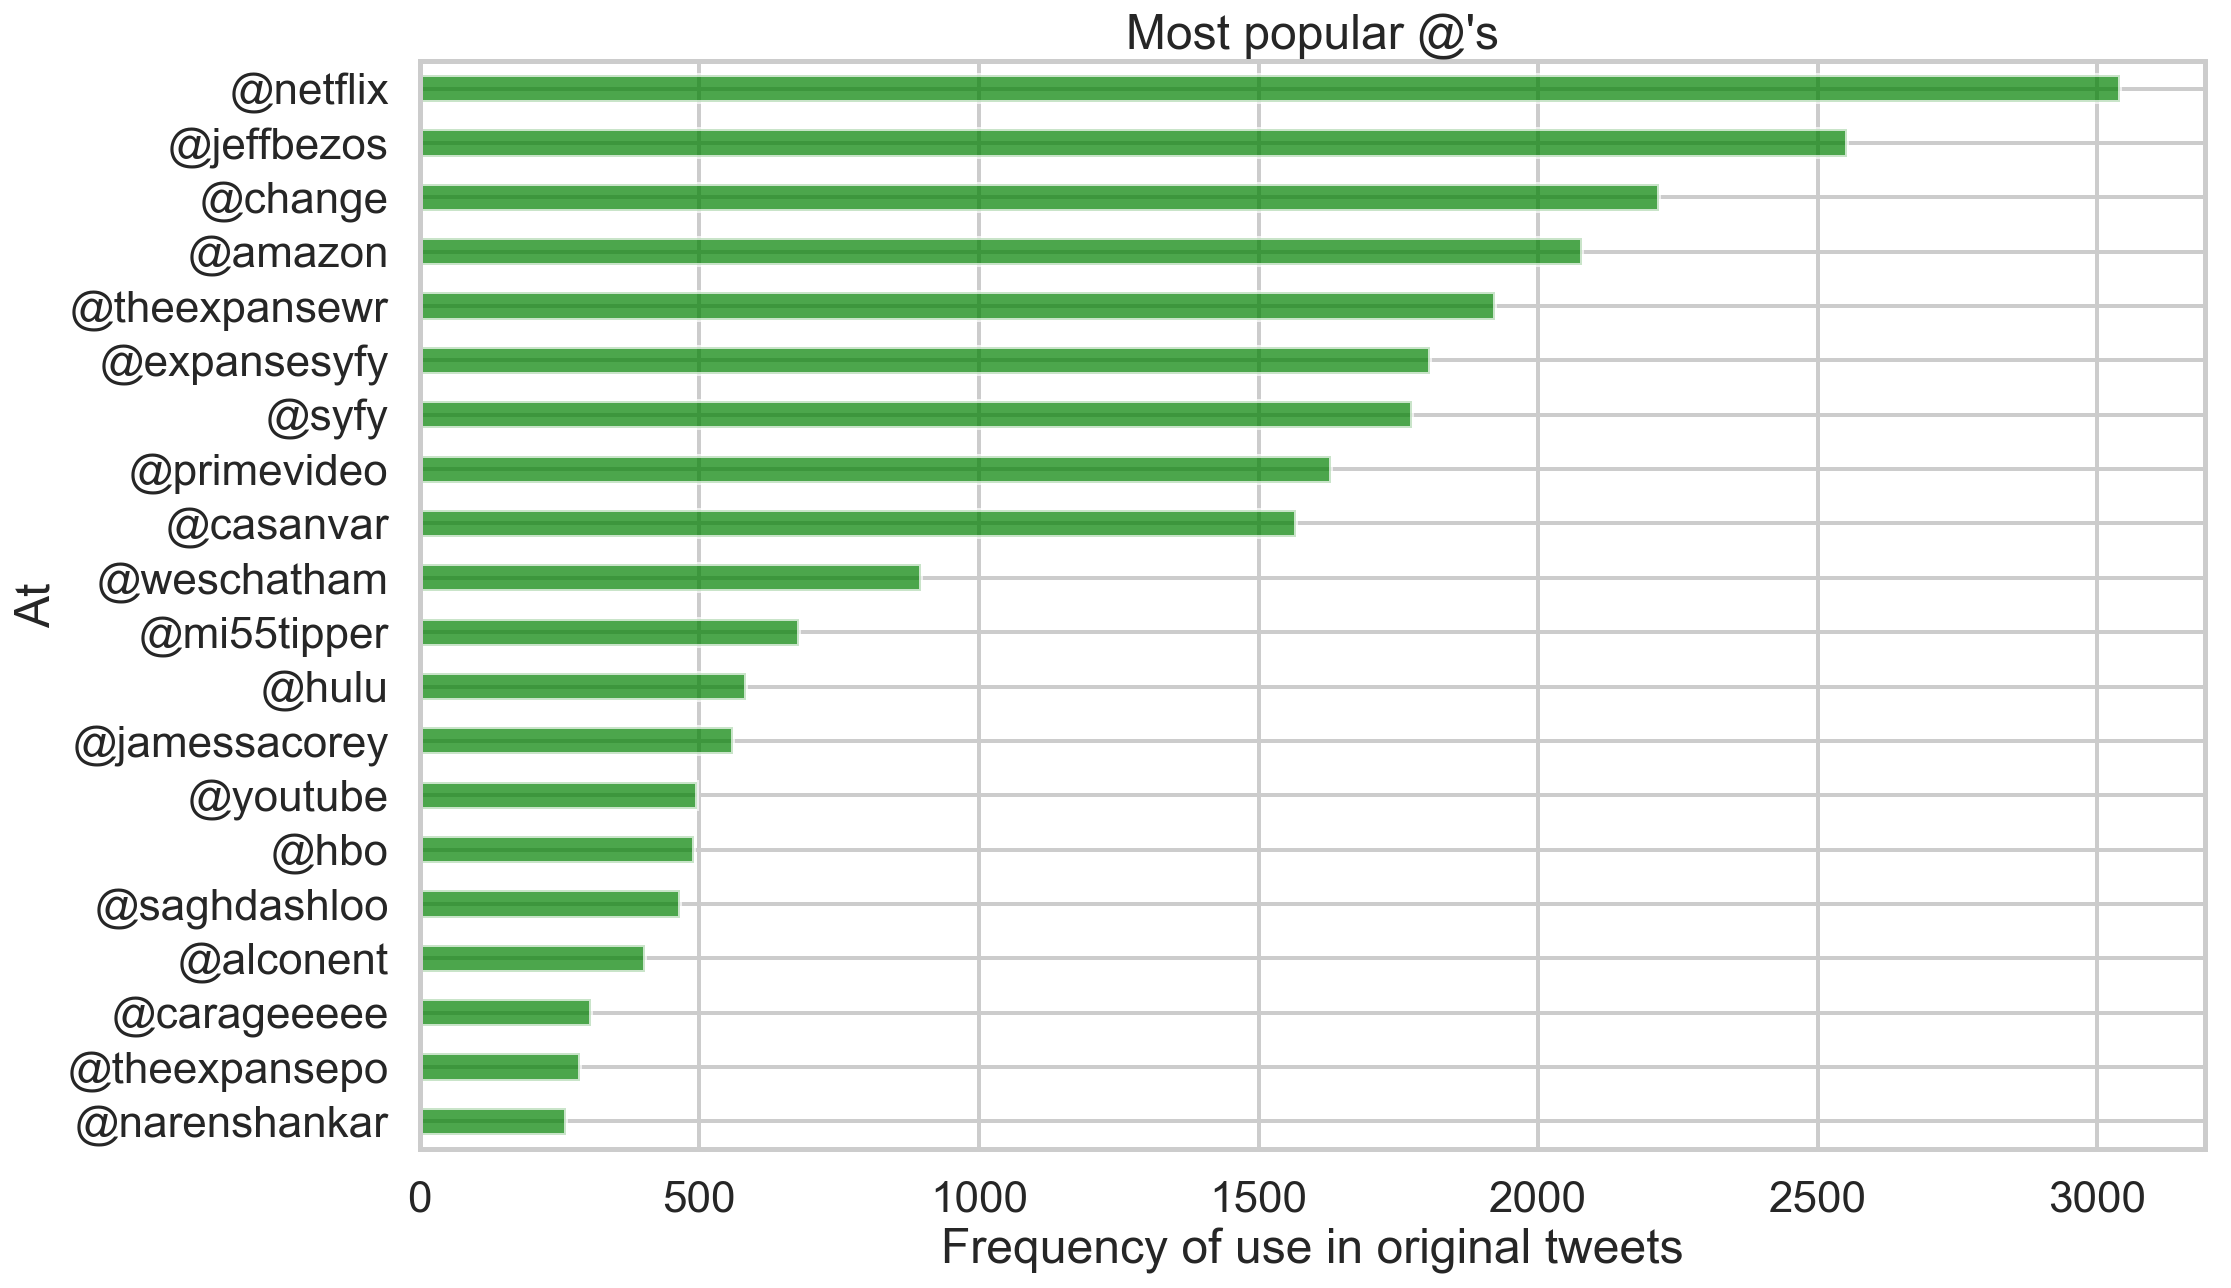

In [19]:
ats = list()
for tweet in df['text'].str.lower():
    ats.extend(re.findall(r'@[a-z|\d]*', tweet))
ats = pd.Series(ats)

ats = ats.value_counts()[1:21]
ats = ats.sort_values(ascending=True)
ax = ats.plot.barh(
    figsize=(16,10),
    color='green',
    alpha=0.7,
)

ax.set(
    title='Most popular @\'s',
    xlabel='Frequency of use in original tweets',
    ylabel='At'
)

# Word cloud

In [22]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [20]:
tokens = list()
stop_words = [
    'the', 'to', '…', 'and', 'a', 'i', 'is', 'you', 'of', 'it', 'this', '-',
    'on', 'for', 'in', 'that', 'we', 'or', 'so', 'be', 'my', 'with', 'are',
    'have', 'but', 'not', 'was', 'do', 'one', "it's", 'as', 'at',
]

for tweet in df['text'].str.lower():
    tweet_tokens = tweet.split()
    for token in tweet_tokens:
        if token.startswith(('#', '@')):
            continue
        if '.com' in token or 'http' in token or ('.' in token and '/' in token):
            continue
        token = re.sub(r'#|@|!|\.|"|\?|&|\*|\(|\)|,', ' ', token)
        token = token.strip()
        if token in stop_words:
            continue
        if token:
            tokens.append(token)
            
tokens = pd.Series(tokens)
tokens = tokens.value_counts()

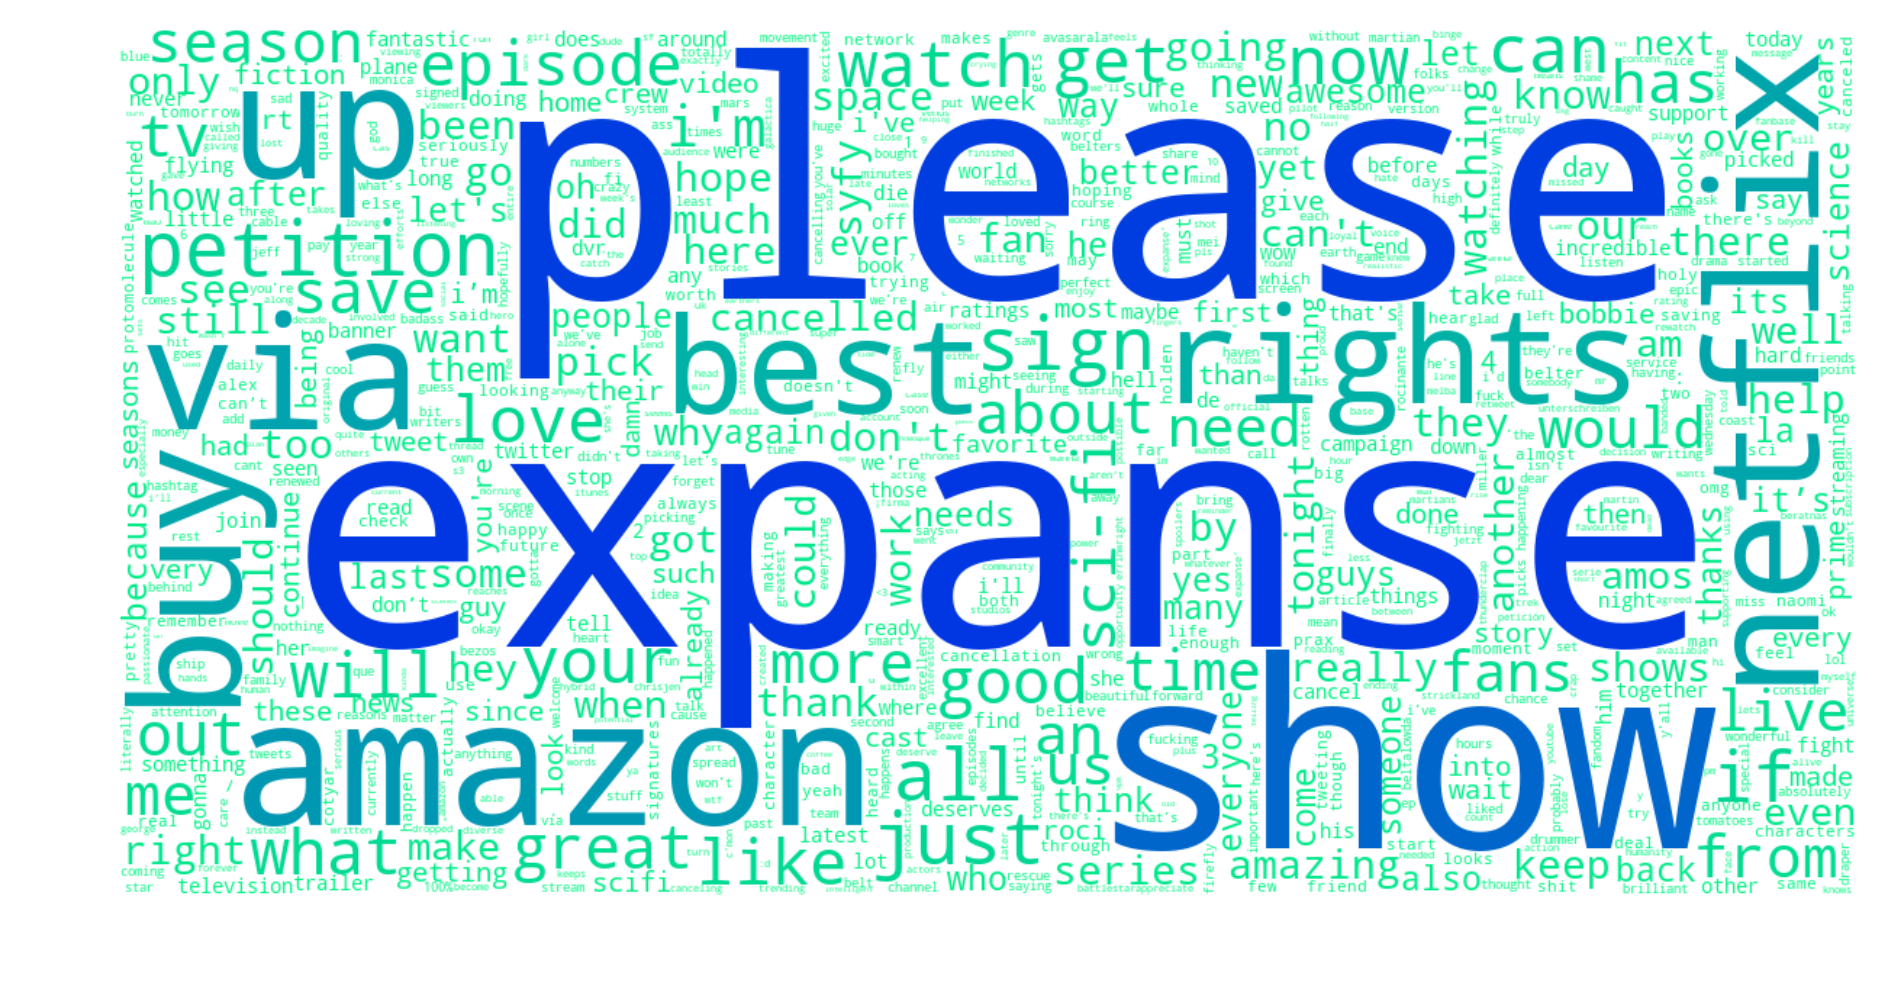

In [28]:
# make word cloud
word_freq_dict = dict(tokens)
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');